In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_curve, auc

In [2]:
# load data
data = pd.read_csv('data/combineVle.csv')
data.shape

(25843, 19)

In [3]:
data.rename(columns={'total_score*weight':'total_score'}, inplace=True)
# when relevant columns have null value, drop null
columns_to_drop=["age_band", "highest_education", "imd_band", "module_presentation", "total_score", "total_click"]
data = data.dropna(subset=columns_to_drop, axis=0)
data.shape

(24845, 19)

In [7]:
studentNum = data.groupby('id_student').count()
studentNum.shape

(22488, 18)

In [8]:
courseNum = len(data.groupby('module_presentation').count())
courseNum

22

In [4]:
# process data, change string to integer
# change age_band
data["age_band"] = data["age_band"].map({"0-35":1, "35-55":2, "55<=":3})

# preprocess "edu" column
data["highest_education"] = data["highest_education"] .map({"No Formal quals":0, "Lower Than A Level":1, "A Level or Equivalent":2, "HE Qualification":3, "Post Graduate Qualification":4})

# change imd_band 
data["imd_band"] = data["imd_band"].map({"0-10%":0, "10-20%":1, "20-30%":2, "30-40%":3, "40-50%":4, "50-60%":5, "60-70%":6, "70-80%":7, "80-90%":8, "90-100%":9})

# change module_presentation
change={"AAA_2013J":1, "AAA_2014J":2, "BBB_2013B":3, "BBB_2013J":4, "BBB_2014B":5, "BBB_2014J":6, "CCC_2014B":7, "CCC_2014J":8,\
        "DDD_2013B":9, "DDD_2013J":10, "DDD_2014B":11, "DDD_2014J":12, "EEE_2013J":13, "EEE_2014B":14, "EEE_2014J":15,\
        "FFF_2013B":16, "FFF_2013J":17, "FFF_2014B":18, "FFF_2014J":19, "GGG_2013J":20, "GGG_2014B":21, "GGG_2014J":22}
data["module_presentation"] = data["module_presentation"].map(change)

# change gender
data["gender"] = data["gender"].map({"M":1, "F":0})

#change disability
data["disability"] = data["disability"].map({"N":0, "Y":1})

# change final_result, don't need to transfer
# data["final_result"] = data["final_result"].map({"Withdrawn":0,  "Fail":0,  "Pass":1, "Distinction":1})
data.shape

(24845, 19)

In [5]:
extracted_data=data[['imd_band', 'age_band', 'highest_education', 'module_presentation', 'total_click','gender', 'disability','num_of_prev_attempts','studied_credits']]
extracted_data.head()

,imd_band,age_band,highest_education,module_presentation,total_click,gender,disability,num_of_prev_attempts,studied_credits
0,8,3,3,2,2791.0,1,0,0,60
1,3,3,3,10,646.0,1,0,0,90
2,3,3,3,12,10.0,1,0,1,60
3,9,3,3,1,934.0,1,0,0,240
4,2,1,1,3,161.0,0,0,2,60


In [6]:
# K-Means clustering
km = KMeans(n_clusters=4,init = 'k-means++')
y_predicted = km.fit_predict(extracted_data)

# Assign cluster labels to train data
data['cluster'] = y_predicted
y_predicted

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


array([1, 0, 0, ..., 3, 0, 0], dtype=int32)

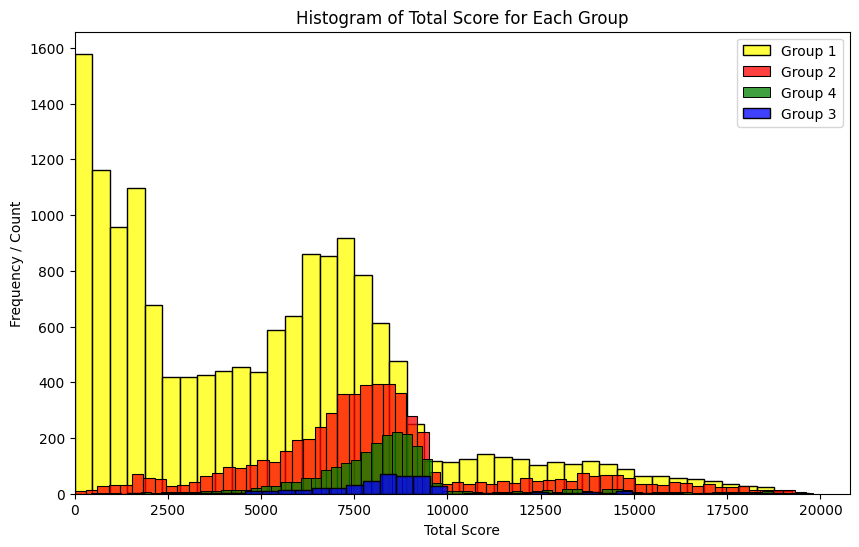

In [9]:
df1 = data[data['cluster']==0]
df2 = data[data['cluster']==1]
df3 = data[data['cluster']==2]
df4 = data[data['cluster']==3]

fig = plt.figure(figsize=(10,6))
sns.histplot(df1['total_score'], color='yellow', label='Group 1')
sns.histplot(df2['total_score'], color='red', label='Group 2')
sns.histplot(df4['total_score'], color='green', label='Group 4')
sns.histplot(df3['total_score'], color='blue', label='Group 3')

plt.legend()
plt.xlabel('Total Score')
plt.ylabel('Frequency / Count')
plt.title('Histogram of Total Score for Each Group')

plt.xlim(left=0)  # Adjust the x-axis limit to include 0
plt.ylim(bottom=0)  # Adjust the y-axis limit to include 0

plt.show()

In [10]:
print(df1.shape, df2.shape, df3.shape, df4.shape)

(15809, 20) (6200, 20) (452, 20) (2384, 20)


In [ ]:
pd.DataFrame(data).to_csv("data/groupeddata2.csv")

# Random forest
based on grouped data by K-Means clustering
cluster=0 in the middle, means pass
cluster=1 in the left means fail
cluster=2 in the right means distinction

In [ ]:
# load data
df = pd.read_csv('data/groupeddata2.csv')
df.shape

In [ ]:
# only keep relevant columns
df = df[['total_score','gender','highest_education','imd_band','age_band','num_of_prev_attempts',\
         'studied_credits','disability','final_result','module_presentation','total_click','cluster']].copy()
df

In [ ]:
# # process data, change string to integer

# change final_result
df["final_result"] = df["final_result"].map({"Withdrawn":0,  "Fail":0,  "Pass":1, "Distinction":1})

# change gender
# df["gender"] = df["gender"].map({"M":1, "F":0})

#change disability
df["disability"] = df["disability"].map({"N":0, "Y":1})
df

In [ ]:
# drop null
df.dropna(inplace=True)
df.shape

In [ ]:
# define Random forest
def randomforest(data):
    # dividing data to train data and test data
    train_df, test_df = np.split(data.sample(frac=1, random_state=1729), [int(0.8 * len(data))])
    print(train_df.shape, test_df.shape)
    # random forecast
    features = list(train_df.columns)
    label = "final_result"  # target label
    compare_label = "total_score"
        
    print("Building training and testing datasets")
    print()
        
    X_train = train_df.drop(columns=[label, compare_label], axis=1)
    y_train = train_df[label]
    # when testing model, need to drop total_score and final_result, cause they are similar
    X_test = test_df.drop(columns=[label, compare_label], axis=1)
    y_test = test_df[label]

    print('Column order: ')
    print(features)
    print()
        
    print("Label column is: ",label)
    print()
        
    print("Data Shape: ")
    print()
    print("---- SHAPE OF TRAINING DATA (80%) ----")
    print(X_train.shape)
    print(y_train.shape)
    print()
    print("---- SHAPE OF TESTING DATA (20%) ----")
    print(X_test.shape)
    print(y_test.shape)
    print()
        
    
    print("Training RandomForest Model.....")
    print()
    n_estimators=100
    # max_features=5
    model =  RandomForestClassifier(n_estimators=n_estimators, verbose = 3,n_jobs=-1)
    model.fit(X_train, y_train)
    print()
    # cluster == 1, predict should be 0  
    y_pred_test = model.predict(X_test)
    X_test['predict'] = y_pred_test
    test_acc = accuracy_score(y_test,y_pred_test)
    test_rep = classification_report(y_test,y_pred_test)

    print()
    print("---- METRICS RESULTS FOR TESTING DATA ----")
    print()
    print("Total Rows are: ", X_test.shape[0])
    print('[TESTING] Model Accuracy is: ', test_acc)
    print('[TESTING] Testing Report: ')
    print(test_rep)

In [ ]:
df1 = df[df['cluster']==0]
df2 = df[df['cluster']==1]
df3 = df[df['cluster']==2]
df4 = df[df['cluster']==3]
print(df1.shape, df2.shape, df3.shape, df4.shape)

In [ ]:
randomforest(df1)

In [ ]:
randomforest(df2)

In [ ]:
randomforest(df3)

In [ ]:
randomforest(df4)

In [ ]:
# using random forest without cluster
nonCluster_df = df[['total_score', 'gender','highest_education','imd_band','age_band','num_of_prev_attempts',\
         'studied_credits','disability','final_result','module_presentation','total_click']].copy()
nonCluster_df

In [ ]:
randomforest(nonCluster_df)